# Adding DM-Baryon Relative Velocities

This notebook shows how to include the effect of the DM-baryon relative velocities, and
the EOS2021 parameters.

Based on Muñoz+21 (https://arxiv.org/abs/2110.13919). See 
https://drive.google.com/drive/folders/1-50AO-i3arCnfHc22YWXJacs4u-xsPL6?usp=sharing for 
the large (1.5Gpc) AllGalaxies simulation with the same parameters.
Note that this notebook has been updated to use 21cmFASTv4, while EOS2021 was run with
21cmFASTv3. The results will be slightly different due to various small fixes and 
improvements in v4, but the basic physics is still the same.

It is recommended to do the other tutorials first.

In [1]:
import matplotlib
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colormaps
import py21cmfast as p21c
from py21cmfast import plotting
from tempfile import mkdtemp

random_seed = 1605

EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list(
    "mycmap",
    [
        (0, "white"),
        (0.33, "yellow"),
        (0.5, "orange"),
        (0.68, "red"),
        (0.83333, "black"),
        (0.9, "blue"),
        (1, "cyan"),
    ],
)
colormaps.register(cmap=EoR_colour)

## Fiducial and lightcones

Let's fix the initial condition for this tutorial.

In [ ]:
output_dir = mkdtemp()

inputs = p21c.InputParameters.from_template(
    'Munoz21', random_seed=911, 
    node_redshifts=p21c.get_logspaced_redshifts(
        min_redshift=5, max_redshift=35.0, z_step_factor=1.06
    )
).evolve_input_structs(
    HII_DIM=64,
    DIM=172,
    BOX_LEN=200,
    
)

initial_conditions = p21c.compute_initial_conditions(
    inputs=inputs,
    cache=p21c.OutputCache(output_dir),
)

In [1]:
len(inputs.node_redshifts)

NameError: name 'inputs' is not defined

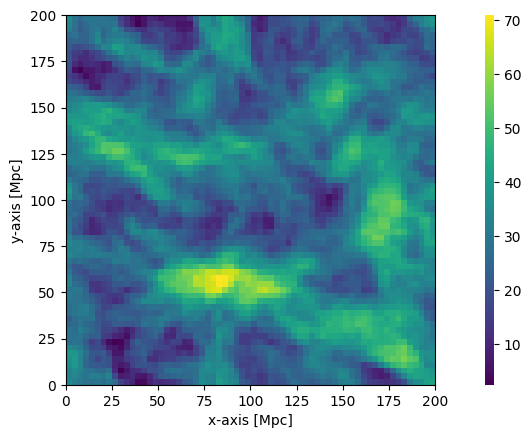

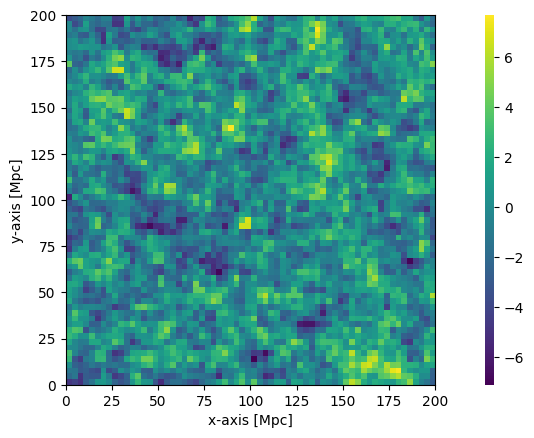

In [3]:
plotting.coeval_sliceplot(initial_conditions, "lowres_vcb")
plotting.coeval_sliceplot(initial_conditions, "lowres_density");

Let's run a 'fiducial' model and see its lightcones

Note that the reference model has `F_STAR7_MINI` ~ `F_STAR10`and `F_ESC7_MINI` ~ 1%, 
as low, but conservative fiducial. Also we take `L_X_MINI=L_X` out of simplicity 
(and ignorance).

In [4]:
# the lightcones we want to plot later together with their color maps and min/max
lightcone_quantities = (
    "brightness_temp",
    "Ts_box",
    "xH_box",
    "dNrec_box",
    "z_re_box",
    "Gamma12_box",
    "J_21_LW_box",
    "density",
)
cmaps = [
    EoR_colour,
    "Reds",
    "magma",
    "magma",
    "magma",
    "cubehelix",
    "cubehelix",
    "viridis",
]
vmins = [-150, 1e1, 0, 0, 5, 0, 0, -1]
vmaxs = [30, 1e3, 1, 2, 9, 1, 10, 1]


inputs_no_vcb = inputs.evolve_input_structs(A_VCB=0)

# the flag FIX_VCB_AVG side-steps the relative-velocity ICs, and instead fixes all velocities to some average value.
# It gets the background right but it's missing VAOs and 21cm power at large scales
inputs_vavg = inputs.evolve_input_structs(FIX_VCB_AVG=True)


AttributeError: 'tuple' object has no attribute 'brightness_temp'

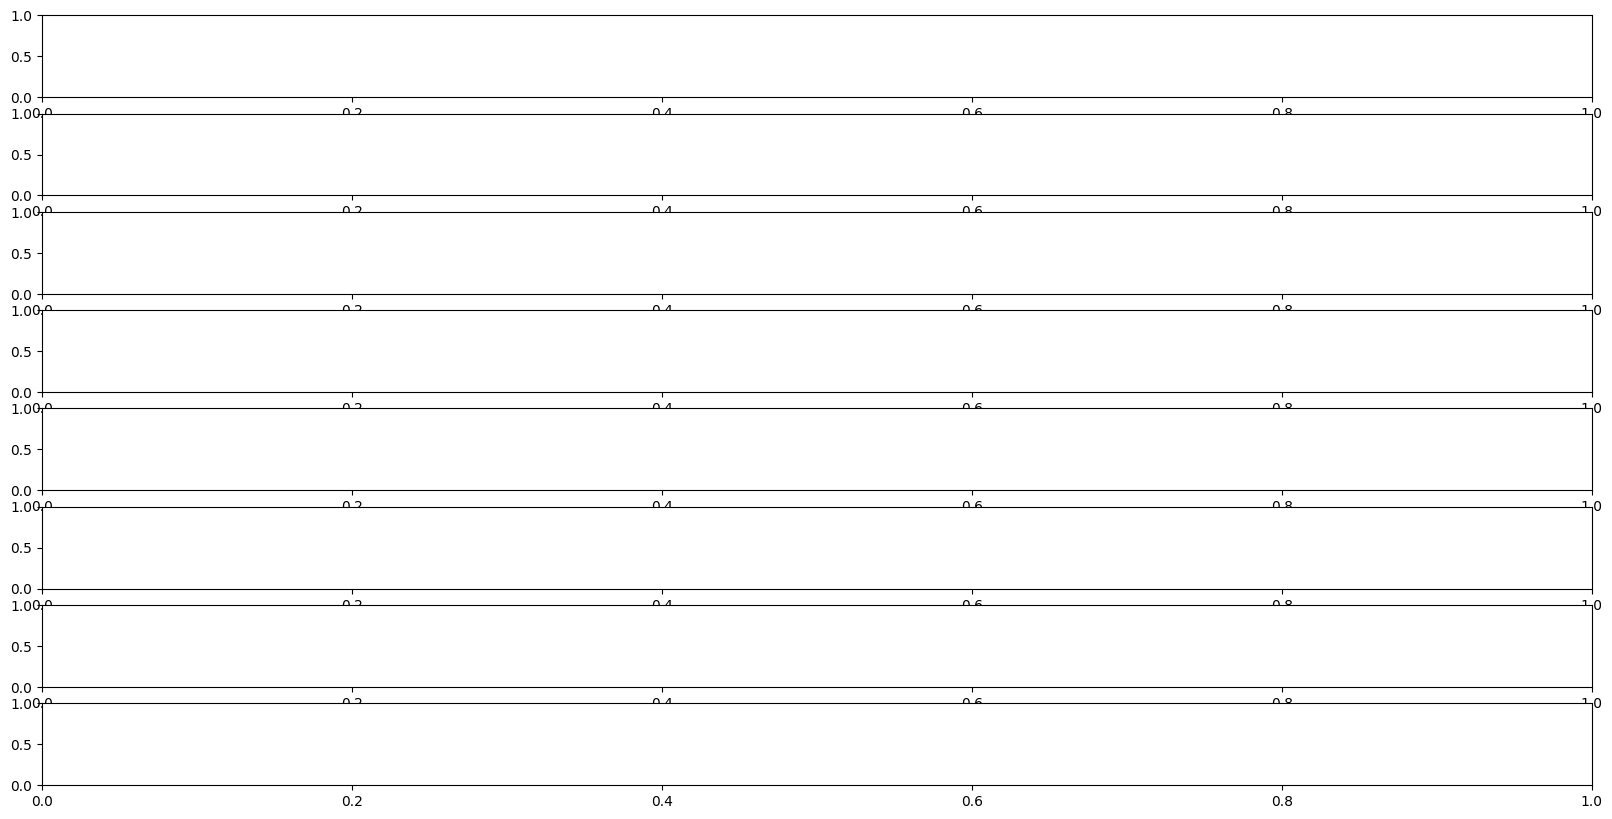

In [ ]:
lcn = p21c.RectilinearLightconer.with_equal_cdist_slices(
    min_redshift=5.0,
    max_redshift=35.0,
    quantities=lightcone_quantities,
    resolution=inputs.simulation_options.cell_size,
)

_, _, _, lightcone_fid_vcb = p21c.run_lightcone(
    lightconer=lcn, 
    initial_conditions=initial_conditions,
    global_quantities=lightcone_quantities,
    cache=p21c.OutputCache(output_dir),
    write=True,
)

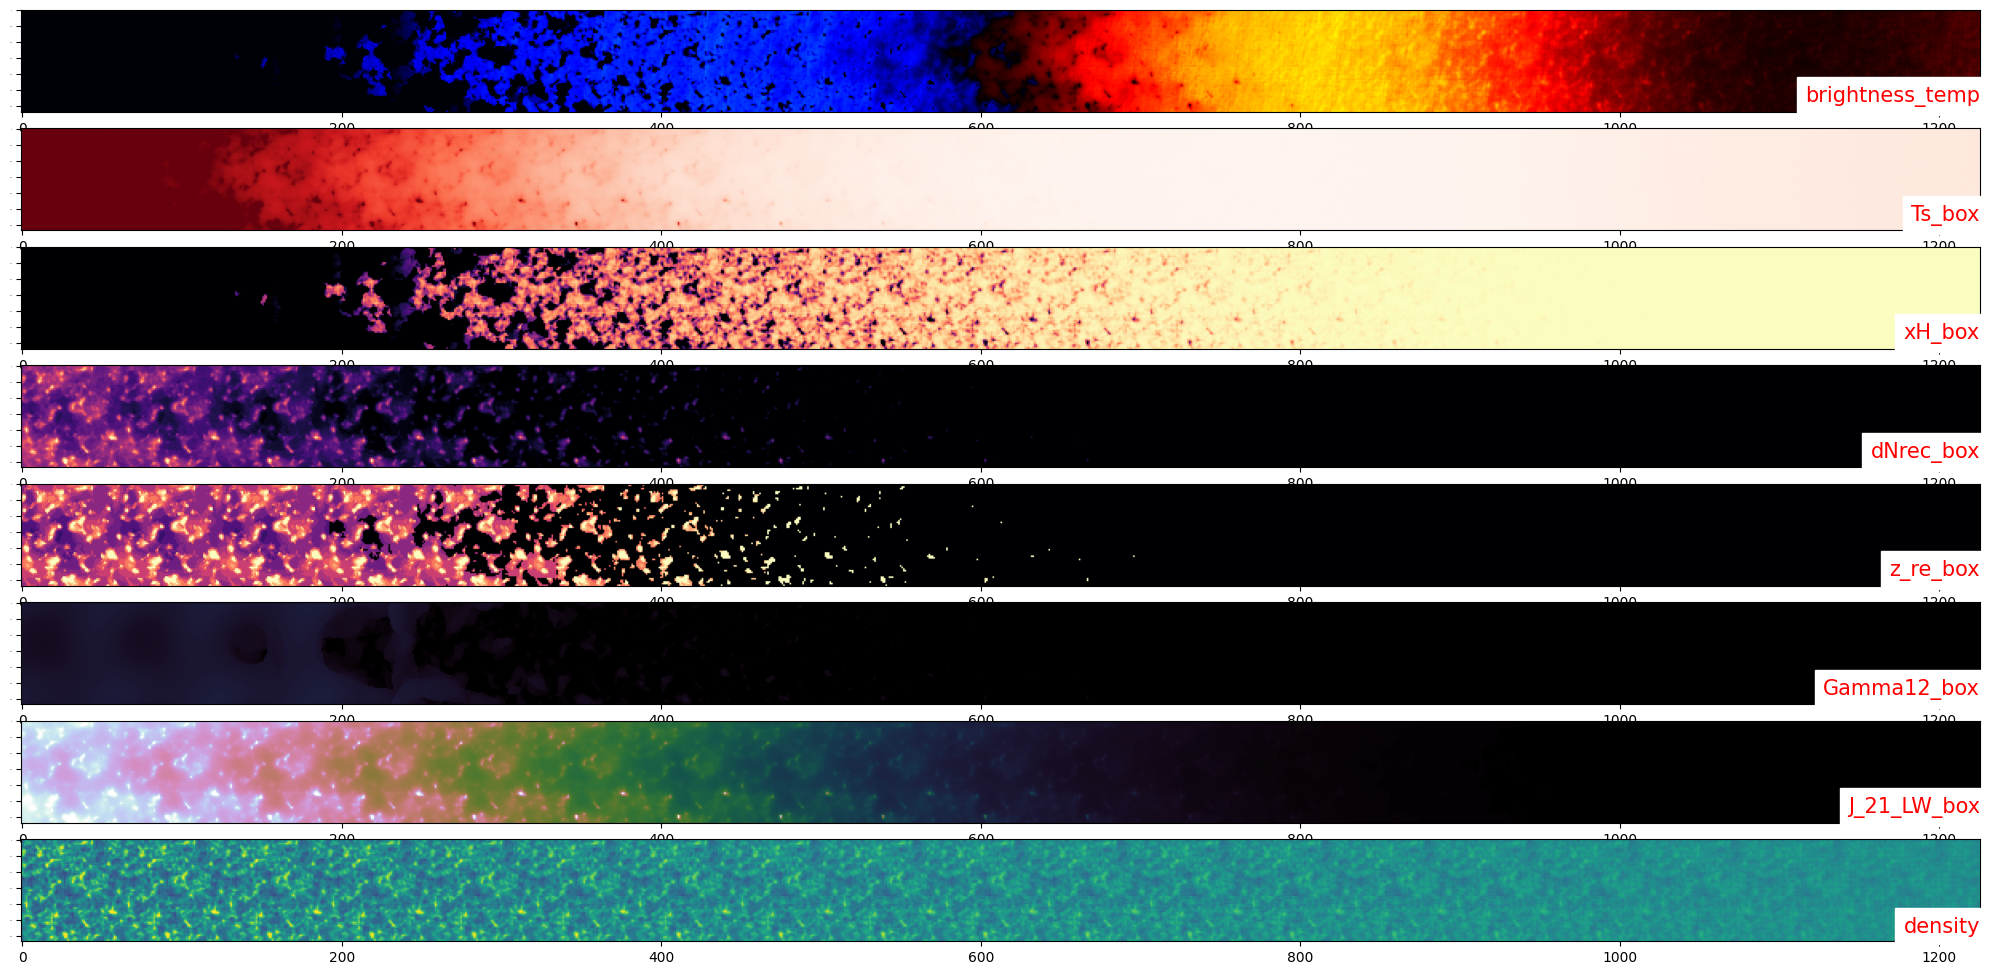

In [12]:
fig, axs = plt.subplots(
    len(lightcone_quantities), 1, figsize=(20, 10)
)
for ii, lightcone_quantity in enumerate(lightcone_quantities):
    axs[ii].imshow(
        lightcone_fid_vcb.lightcones[lightcone_quantity][1],
        vmin=vmins[ii],
        vmax=vmaxs[ii],
        cmap=cmaps[ii],
    )
    axs[ii].text(
        1,
        0.05,
        lightcone_quantity,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=axs[ii].transAxes,
        color="red",
        backgroundcolor="white",
        fontsize=15,
    )
    axs[ii].xaxis.set_tick_params(labelsize=10)
    axs[ii].yaxis.set_tick_params(labelsize=0)
plt.tight_layout()
fig.subplots_adjust(hspace=0.01)

In [ ]:
# also run one without velocities and with fixed vcb=vavg (for comparison)
lightcone_fid_novcb = p21c.run_lightcone(
    lightconer=lcn, 
    inputs=inputs_no_vcb,
    initial_conditions=initial_conditions,
    global_quantities=lightcone_quantities,
    cache=p21c.OutputCache(output_dir),
    write=True,
)

lightcone_fid_vcbavg = p21c.run_lightcone(
    lightconer=lcn, 
    inputs=inputs_vavg,
    initial_conditions=initial_conditions,
    global_quantities=lightcone_quantities,
    cache=p21c.OutputCache(output_dir),
    write=True,
)


In [ ]:
# plus run one with only atomic-cooling galaxies but same otherwise
inputs_acg = inputs.evolve_input_structs(USE_MINI_HALOS=False)
lightcone_fid_acg = p21c.run_lightcone(
    lightconer=lcn, 
    inputs=inputs_acg,
    initial_conditions=initial_conditions,
    global_quantities=lightcone_quantities,
    cache=p21c.OutputCache(output_dir),
    write=True,
)

In [ ]:
# compare vcb and novcb

fig, axs = plt.subplots(2, 1, figsize=(20, 6))

axs[0].imshow(
    lightcone_fid_vcb.brightness_temp[1], vmin=vmins[0], vmax=vmaxs[0], cmap=cmaps[0]
)
axs[1].imshow(
    lightcone_fid_novcb.brightness_temp[1], vmin=vmins[0], vmax=vmaxs[0], cmap=cmaps[0]
)
axs[0].text(
    1,
    0.05,
    "vcb",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=axs[0].transAxes,
    color="red",
    backgroundcolor="white",
    fontsize=15,
)
axs[1].text(
    1,
    0.05,
    "novcb",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=axs[1].transAxes,
    color="red",
    backgroundcolor="white",
    fontsize=15,
)
# axs[0].xaxis.set_tick_params(labelsize=10)
# axs[1].yaxis.set_tick_params(labelsize=0)
plt.tight_layout()
fig.subplots_adjust(hspace=0.01)

In [ ]:
# plot tau

tau_vcb = tau_novcb = tau_NOMINI = np.array([])
for il, lightcone in enumerate(
    [lightcone_fid_vcb, lightcone_fid_novcb, lightcone_fid_acg]
):
    z_e = np.array([])
    tau_e = np.array([])
    for i in range(len(lightcone.node_redshifts) - 1):
        tauz = p21c.compute_tau(
            redshifts=lightcone.node_redshifts[-1 : -2 - i : -1],
            global_xHI=lightcone.global_xHI[-1 : -2 - i : -1],
        )
        tau_e = np.append(tau_e, tauz)
        z_e = np.append(z_e, lightcone.node_redshifts[-2 - i])

    # add lower zs where we manually set xH=1
    zlow = np.linspace(lightcone.node_redshifts[-1] - 0.1, 0.1, 14)
    for zl in zlow:
        tauz = p21c.compute_tau(
            redshifts=np.array([zl]), global_xHI=np.array([lightcone.global_xHI[-1]])
        )
        tau_e = np.append([tauz], tau_e)
        z_e = np.append([zl], z_e)

    if il == 0:
        tau_vcb = tau_e
    elif il == 1:
        tau_novcb = tau_e
    else:
        tau_NOMINI = tau_e


linestyles = ["-", "-.", ":"]
colors = ["black", "gray", "#377eb8"]
lws = [3, 1, 2]

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 4))

kk = 0
axs.plot(
    z_e, tau_vcb, label="vcb", color=colors[kk], linestyle=linestyles[kk], lw=lws[kk]
)
kk = 1
axs.plot(
    z_e,
    tau_novcb,
    label="no vcb",
    color=colors[kk],
    linestyle=linestyles[kk],
    lw=lws[kk],
)
kk = 2
axs.plot(
    z_e,
    tau_NOMINI,
    label="no MINI",
    color=colors[kk],
    linestyle=linestyles[kk],
    lw=lws[kk],
)

axs.set_ylim(0.0, 0.1)
axs.set_xlabel("redshift", fontsize=15)
axs.xaxis.set_tick_params(labelsize=15)

axs.set_xlim(0.0, 20.0)
axs.set_ylabel("$\\tau$", fontsize=15)
axs.yaxis.set_tick_params(labelsize=15)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

tauPmin = 0.0561 - 0.0071
tauPmax = 0.0561 + 0.0071
axs.axhspan(tauPmin, tauPmax, alpha=0.34, color="black")
axs.grid()

# Planck2020: tau=0.0561±0.0071

In [ ]:
# check that the tau z=15-30 is below 0.02 as Planck requires
tau_vcb[-1] - tau_vcb[55]

In [ ]:
linestyles = ["-", "-.", ":"]
colors = ["black", "gray", "#377eb8"]
lws = [3, 1, 2]
labels = ["vcb", "no vcb", "no MINI"]

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(8, 4))

for kk, lightcone in enumerate(
    [lightcone_fid_vcb, lightcone_fid_novcb, lightcone_fid_acg]
):
    axs.plot(
        lightcone.node_redshifts,
        lightcone.global_xHI,
        label=labels[kk],
        color=colors[kk],
        linestyle=linestyles[kk],
        lw=lws[kk],
    )

axs.set_ylim(0.0, 1.0)
axs.set_xlabel("redshift", fontsize=15)
axs.xaxis.set_tick_params(labelsize=15)

axs.set_xlim(5.0, 20.0)
axs.set_ylabel("$x_{HI}$", fontsize=15)
axs.yaxis.set_tick_params(labelsize=15)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

axs.grid()

In [ ]:
runcache = p21c.RunCache.from_inputs(inputs)

In [ ]:
# choose a redshift to print coeval slices and see if there are VAOs. Usually best then T21~T21min/2
zz = zlist21[40]

In [ ]:
# We plot a coeval box, but we compare the vcb case against the vcb=vavg, since the no velocity (vcb=0) case has a background evolution that is too different.
coeval_fid_vcb = runcache.get_coeval_at_z(inputs.node_redshifts)
p21c.run_coeval(
    redshift=zz,
    init_box=initial_conditions,
    flag_options=flag_options_fid,
    astro_params=astro_params_vcb,
    random_seed=random_seed,
    direc=output_dir,
    write=True,  # , regenerate=True
)

coeval_fid_vcbavg = p21c.run_coeval(
    redshift=zz,
    init_box=initial_conditions,
    flag_options=flag_options_fid_vavg,
    astro_params=astro_params_vcb,
    random_seed=random_seed,
    direc=output_dir,
    write=True,  # , regenerate=True
)

In [ ]:
T21slice_vcb = coeval_fid_vcb.brightness_temp
T21avg_vcb = np.mean(T21slice_vcb)
dT21slice_vcb = T21slice_vcb - T21avg_vcb

T21slice_novcb = coeval_fid_vcbavg.brightness_temp
T21avg_novcb = np.mean(T21slice_novcb)
dT21slice_novcb = T21slice_novcb - T21avg_novcb


sigma21 = np.sqrt(np.var(dT21slice_vcb))

T21maxplot = 3.0 * sigma21
T21minplot = -2.0 * sigma21


origin = "lower"
extend = "both"

origin = None
extend = "neither"

xx = np.linspace(0, BOX_LEN, HII_DIM, endpoint=False)
yy = xx


indexv = 0

fig, ax = plt.subplots(
    2,
    2,
    constrained_layout=True,
    figsize=(10, 8),
    sharex="col",
    sharey="row",
    gridspec_kw={"hspace": 0, "wspace": 0},
)

cs0 = ax[0, 0].contourf(
    xx,
    yy,
    dT21slice_novcb[indexv],
    extend=extend,
    origin=origin,
    vmin=T21minplot,
    vmax=T21maxplot,
    cmap="bwr",
)
fig.colorbar(cs0, ax=ax[0, 0], shrink=0.9, location="left")
cs1 = ax[0, 1].contourf(
    xx,
    yy,
    dT21slice_vcb[indexv],
    extend=extend,
    origin=origin,
    vmin=T21minplot,
    vmax=T21maxplot,
    cmap="bwr",
)
fig.colorbar(cs1, ax=ax[0, 1], shrink=0.9)


deltaslice = initial_conditions.lowres_density
deltaavg = np.mean(deltaslice)
ddeltaslice = deltaslice - deltaavg

vcbslice = initial_conditions.lowres_vcb
vcbavg = np.mean(vcbslice)
dvcbslice = vcbslice


csd = ax[1, 0].contourf(xx, yy, ddeltaslice[indexv])
fig.colorbar(csd, ax=ax[1, 0], shrink=0.9, location="left")
csv = ax[1, 1].contourf(xx, yy, dvcbslice[indexv])
fig.colorbar(csv, ax=ax[1, 1], shrink=0.9, extend=extend)
plt.show()

plt.tight_layout()

In [ ]:
global_quantities = (
    "brightness_temp",
    "Ts_box",
    "xH_box",
    "dNrec_box",
    "z_re_box",
    "Gamma12_box",
    "J_21_LW_box",
    "density",
)
# choose some to plot...
plot_quantities = (
    "brightness_temp",
    "Ts_box",
    "xH_box",
    "dNrec_box",
    "Gamma12_box",
    "J_21_LW_box",
)
ymins = [-120, 1e1, 0, 0, 0, 0]
ymaxs = [30, 1e3, 1, 1, 1, 5]
linestyles = ["-", "-", ":", "-.", "-.", ":"]
colors = ["gray", "black", "#e41a1c", "#377eb8", "#e41a1c", "#377eb8"]
lws = [2, 2, 2, 2]

textss = ["vcb", "MCGs"]
factorss = [
    [0, 1],
] * len(textss)
labelss = [
    ["NO", "reference"],
] * len(textss)


fig, axss = plt.subplots(
    len(plot_quantities),
    len(labelss),
    sharex=True,
    figsize=(4 * len(labelss), 2 * len(plot_quantities)),
)

for pp, texts in enumerate(textss):
    labels = labelss[pp]
    factors = factorss[pp]
    axs = axss[:, pp]
    for kk, label in enumerate(labels):
        factor = factors[kk]

        if kk == 0:
            lightcone = lightcone_fid_acg if pp == 0 else lightcone_fid_novcb
        else:
            lightcone = lightcone_fid_vcb

        freqs = 1420.4 / (np.array(lightcone.node_redshifts) + 1.0)
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].plot(
                freqs,
                getattr(
                    lightcone, "global_{}".format(global_quantity.replace("_box", ""))
                ),
                color=colors[kk],
                linestyle=linestyles[kk],
                label=labels[kk],
                lw=lws[kk],
            )

    axs[0].text(
        0.01,
        0.99,
        texts,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=axs[0].transAxes,
        fontsize=15,
    )
    for jj, global_quantity in enumerate(plot_quantities):
        axs[jj].set_ylim(ymins[jj], ymaxs[jj])
    axs[-1].set_xlabel("Frequency/MHz", fontsize=15)
    axs[-1].xaxis.set_tick_params(labelsize=15)

    axs[0].set_xlim(1420.4 / (35 + 1.0), 1420.4 / (5.5 + 1.0))
    zlabels = np.array([6, 7, 8, 10, 13, 18, 25, 35])
    ax2 = axs[0].twiny()
    ax2.set_xlim(axs[0].get_xlim())
    ax2.set_xticks(1420.4 / (zlabels + 1.0))
    ax2.set_xticklabels(zlabels.astype(str))
    ax2.set_xlabel("redshift", fontsize=15)
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.grid(False)

    if pp == 0:
        axs[0].legend(
            loc="lower right", ncol=2, fontsize=13, fancybox=True, frameon=True
        )
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].set_ylabel(
                "global_{}".format(global_quantity.replace("_box", "")), fontsize=15
            )
            axs[jj].yaxis.set_tick_params(labelsize=15)
    else:
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].set_ylabel(
                "global_{}".format(global_quantity.replace("_box", "")), fontsize=0
            )
            axs[jj].yaxis.set_tick_params(labelsize=0)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

## Varying parameters

let's vary the parameters that describe mini-halos and see the impact to the global signal.
Warning: It may take a while to run all these boxes!

We keep other parameters fixed and vary one of following  by a factor of 1/3 and 3:

    F_STAR7_MINI
    F_ESC7_MINI
    L_X_MINI
    A_LW
    
We also have a NOmini model where mini-halos are not included

In [ ]:
# defining those color, linstyle, blabla
linestyles = ["-", "-", ":", "-.", "-.", ":"]
colors = ["gray", "black", "#e41a1c", "#377eb8", "#e41a1c", "#377eb8"]
lws = [1, 3, 2, 2, 2, 2]

textss = [
    "varying " + r"$f_{*,7}^{\rm mol}$",
    "varying " + r"$f_{\rm esc}^{\rm mol}$",
    "varying " + r"$L_{\rm x}^{\rm mol}$",
    "varying " + r"$A_{\rm LW}$",
]
factorss = [
    [0, 1, 0.33, 3.0],
] * len(textss)
labelss = [
    ["No Velocity", "Fiducial", "/3", "x3"],
] * len(textss)

In [ ]:
global_quantities = (
    "brightness_temp",
    "Ts_box",
    "xH_box",
    "dNrec_box",
    "z_re_box",
    "Gamma12_box",
    "J_21_LW_box",
    "density",
)
# choose some to plot...
plot_quantities = (
    "brightness_temp",
    "Ts_box",
    "xH_box",
    "dNrec_box",
    "Gamma12_box",
    "J_21_LW_box",
)
ymins = [-120, 1e1, 0, 0, 0, 0]
ymaxs = [30, 1e3, 1, 1, 1, 10]

fig, axss = plt.subplots(
    len(plot_quantities),
    len(labelss),
    sharex=True,
    figsize=(4 * len(labelss), 2 * len(global_quantities)),
)

for pp, texts in enumerate(textss):
    labels = labelss[pp]
    factors = factorss[pp]
    axs = axss[:, pp]
    for kk, label in enumerate(labels):
        flag_options = flag_options_fid.copy()
        astro_params = astro_params_vcb.copy()
        factor = factors[kk]
        if label == "No Velocity":
            lightcone = lightcone_fid_novcb
        elif label == "Fiducial":
            lightcone = lightcone_fid_vcb
        else:
            if pp == 0:
                astro_params.update(
                    {
                        "F_STAR7_MINI": astro_params_vcb["F_STAR7_MINI"]
                        + np.log10(factor)
                    }
                )
            elif pp == 1:
                astro_params.update(
                    {"F_ESC7_MINI": astro_params_vcb["F_ESC7_MINI"] + np.log10(factor)}
                )
            elif pp == 2:
                astro_params.update(
                    {"L_X_MINI": astro_params_vcb["L_X_MINI"] + np.log10(factor)}
                )
            elif pp == 3:
                astro_params.update({"A_LW": astro_params_vcb["A_LW"] * factor})
            else:
                pass

            lightcone = p21c.run_lightcone(
                redshift=ZMIN,
                init_box=initial_conditions,
                flag_options=flag_options_fid,
                astro_params=astro_params,
                global_quantities=global_quantities,
                random_seed=random_seed,
                direc=output_dir,
            )

        freqs = 1420.4 / (np.array(lightcone.node_redshifts) + 1.0)
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].plot(
                freqs,
                getattr(
                    lightcone, "global_{}".format(global_quantity.replace("_box", ""))
                ),
                color=colors[kk],
                linestyle=linestyles[kk],
                label=labels[kk],
                lw=lws[kk],
            )

    axs[0].text(
        0.01,
        0.99,
        texts,
        horizontalalignment="left",
        verticalalignment="top",
        transform=axs[0].transAxes,
        fontsize=15,
    )
    for jj, global_quantity in enumerate(plot_quantities):
        axs[jj].set_ylim(ymins[jj], ymaxs[jj])
    axs[-1].set_xlabel("Frequency/MHz", fontsize=15)
    axs[-1].xaxis.set_tick_params(labelsize=15)

    axs[0].set_xlim(1420.4 / (35 + 1.0), 1420.4 / (5.5 + 1.0))
    zlabels = np.array([6, 7, 8, 10, 13, 18, 25, 35])
    ax2 = axs[0].twiny()
    ax2.set_xlim(axs[0].get_xlim())
    ax2.set_xticks(1420.4 / (zlabels + 1.0))
    ax2.set_xticklabels(zlabels.astype(str))
    ax2.set_xlabel("redshift", fontsize=15)
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.grid(False)

    if pp == 0:
        axs[0].legend(
            loc="lower right", ncol=2, fontsize=13, fancybox=True, frameon=True
        )
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].set_ylabel(
                "global_{}".format(global_quantity.replace("_box", "")), fontsize=15
            )
            axs[jj].yaxis.set_tick_params(labelsize=15)
    else:
        for jj, global_quantity in enumerate(plot_quantities):
            axs[jj].set_ylabel(
                "global_{}".format(global_quantity.replace("_box", "")), fontsize=0
            )
            axs[jj].yaxis.set_tick_params(labelsize=0)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
# define functions to calculate PS, following py21cmmc
from powerbox.tools import get_power


def compute_power(
    box,
    length,
    n_psbins,
    log_bins=True,
    ignore_kperp_zero=True,
    ignore_kpar_zero=False,
    ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, dtype=int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res


def powerspectra(
    brightness_temp, n_psbins=50, nchunks=10, min_k=0.1, max_k=1.0, logk=True
):
    data = []
    chunk_indices = list(
        range(
            0,
            brightness_temp.n_slices,
            round(brightness_temp.n_slices / nchunks),
        )
    )

    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k**3 / (2 * np.pi**2)})
    return data

In [ ]:
# do 5 chunks but only plot 1 - 4, the 0th has no power for minihalo models where xH=0
nchunks = 4
k_fundamental = 2 * np.pi / BOX_LEN
k_max = k_fundamental * HII_DIM
Nk = np.floor(HII_DIM / 1).astype(int)

fig, axss = plt.subplots(
    nchunks,
    len(labelss),
    sharex=True,
    sharey=True,
    figsize=(4 * len(labelss), 3 * (nchunks)),
    subplot_kw={"xscale": "log", "yscale": "log"},
)

for pp, texts in enumerate(textss):
    labels = labelss[pp]
    factors = factorss[pp]
    axs = axss[:, pp]
    for kk, label in enumerate(labels):
        flag_options = flag_options_fid.copy()
        astro_params = astro_params_vcb.copy()
        factor = factors[kk]
        if label == "No Velocity":
            lightcone = lightcone_fid_novcb
        elif label == "Fiducial":
            lightcone = lightcone_fid_vcb
        else:
            if pp == 0:
                astro_params.update(
                    {
                        "F_STAR7_MINI": astro_params_vcb["F_STAR7_MINI"]
                        + np.log10(factor)
                    }
                )
            elif pp == 1:
                astro_params.update(
                    {"F_ESC7_MINI": astro_params_vcb["F_ESC7_MINI"] + np.log10(factor)}
                )
            elif pp == 2:
                astro_params.update(
                    {"L_X_MINI": astro_params_vcb["L_X_MINI"] + np.log10(factor)}
                )
            elif pp == 3:
                astro_params.update(
                    {"A_LW": astro_params_vcb["A_LW"] + np.log10(factor)}
                )
            else:
                pass

            lightcone = p21c.run_lightcone(
                redshift=ZMIN,
                init_box=initial_conditions,
                flag_options=flag_options_fid,
                astro_params=astro_params,
                global_quantities=global_quantities,
                random_seed=random_seed,
                direc=output_dir,
            )

        PS = powerspectra(lightcone, min_k=k_fundamental, max_k=k_max)

        for ii in range(nchunks):
            axs[ii].plot(
                PS[ii + 1]["k"],
                PS[ii + 1]["delta"],
                color=colors[kk],
                linestyle=linestyles[kk],
                label=labels[kk],
                lw=lws[kk],
            )

            if pp == len(textss) - 1 and kk == 0:
                axs[ii].text(
                    0.99,
                    0.01,
                    "Chunk-%02d" % (ii + 1),
                    horizontalalignment="right",
                    verticalalignment="bottom",
                    transform=axs[ii].transAxes,
                    fontsize=15,
                )

    axs[0].text(
        0.01,
        0.99,
        texts,
        horizontalalignment="left",
        verticalalignment="top",
        transform=axs[0].transAxes,
        fontsize=15,
    )

    axs[-1].set_xlabel("$k$ [Mpc$^{-3}$]", fontsize=15)
    axs[-1].xaxis.set_tick_params(labelsize=15)

    if pp == 0:
        for ii in range(nchunks):
            axs[ii].set_ylim(2e-1, 2e2)
            axs[ii].set_ylabel("$k^3 P$", fontsize=15)
            axs[ii].yaxis.set_tick_params(labelsize=15)
    else:
        for ii in range(nchunks - 1):
            axs[ii].set_ylim(2e-1, 2e2)
            axs[ii].set_ylabel("$k^3 P$", fontsize=0)
            axs[ii].yaxis.set_tick_params(labelsize=0)

axss[0, 0].legend(loc="lower left", ncol=2, fontsize=13, fancybox=True, frameon=True)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

Note that I've run these simulations in parallel before this tutorial. With these setup, each took ~6h to finish. Here, running means read the cached outputs.

## global properties -- optical depth

In [ ]:
# defining those color, linstyle, blabla
linestyles = ["-", "-", ":", "-.", "-.", ":"]
colors = ["gray", "black", "#e41a1c", "#377eb8", "#e41a1c", "#377eb8"]
lws = [1, 3, 2, 2, 2, 2]

textss_tau = [
    "varying " + r"$f_{*,7}^{\rm mol}$",
    "varying " + r"$f_{\rm esc}^{\rm mol}$",
    "varying " + r"$A_{\rm LW}$",
]

factorss_tau = [
    [0, 1, 0.33, 3.0],
] * len(textss_tau)
labelss_tau = [
    ["No Velocity", "Fiducial", "/3", "x3"],
] * len(textss_tau)

In [ ]:
plot_quantities = ["tau_e"]
ymins = [0]
ymaxs = [0.2]


fig, axss_tau = plt.subplots(
    len(plot_quantities),
    len(labelss_tau),
    sharex=True,
    figsize=(4 * len(labelss_tau), 3 * len(plot_quantities)),
)


for pp, texts in enumerate(textss_tau):
    labels = labelss_tau[pp]
    factors = factorss_tau[pp]
    axs = axss_tau[pp]
    for kk, label in enumerate(labels):
        flag_options = flag_options_fid.copy()
        astro_params = astro_params_vcb.copy()
        factor = factors[kk]
        if label == "No Velocity":
            lightcone = lightcone_fid_novcb
        elif label == "Fiducial":
            lightcone = lightcone_fid_vcb
        else:
            if pp == 0:
                astro_params.update(
                    {
                        "F_STAR7_MINI": astro_params_vcb["F_STAR7_MINI"]
                        + np.log10(factor)
                    }
                )
            elif pp == 1:
                astro_params.update(
                    {"F_ESC7_MINI": astro_params_vcb["F_ESC7_MINI"] + np.log10(factor)}
                )
            elif pp == 2:
                astro_params.update({"A_LW": astro_params_vcb["A_LW"] * factor})
            else:
                pass

            lightcone = p21c.run_lightcone(
                redshift=ZMIN,
                init_box=initial_conditions,
                flag_options=flag_options_fid,
                astro_params=astro_params,
                global_quantities=global_quantities,
                random_seed=random_seed,
                direc=output_dir,
            )

        z_e = np.array([])
        tau_e = np.array([])
        for i in range(len(lightcone.node_redshifts) - 1):
            tauz = p21c.compute_tau(
                redshifts=lightcone.node_redshifts[-1 : -2 - i : -1],
                global_xHI=lightcone.global_xHI[-1 : -2 - i : -1],
            )
            tau_e = np.append(tau_e, tauz)
            z_e = np.append(z_e, lightcone.node_redshifts[-2 - i])
            # print(i,lightcone.node_redshifts[i],tauz)

        # add lower zs where we manually set xH=1
        zlow = np.linspace(lightcone.node_redshifts[-1] - 0.1, 0.1, 14)
        for zl in zlow:
            tauz = p21c.compute_tau(
                redshifts=np.array([zl]),
                global_xHI=np.array([lightcone.global_xHI[-1]]),
            )
            tau_e = np.append([tauz], tau_e)
            z_e = np.append([zl], z_e)

        #        freqs = 1420.4 / (np.array(lightcone.node_redshifts) + 1.)
        for jj, global_quantity in enumerate(plot_quantities):
            axs.plot(
                z_e,
                tau_e,
                color=colors[kk],
                linestyle=linestyles[kk],
                label=labels[kk],
                lw=lws[kk],
            )

    axs.text(
        0.01,
        0.99,
        texts,
        horizontalalignment="left",
        verticalalignment="top",
        transform=axs.transAxes,
        fontsize=15,
    )
    axs.set_ylim(ymins[0], ymaxs[0])
    axs.set_xlabel("redshift", fontsize=15)
    axs.xaxis.set_tick_params(labelsize=15)

    axs.set_xlim(0.0, 20.0)

    if pp == 0:
        for ii in range(nchunks):
            axs.set_ylabel("$\\tau$", fontsize=15)
            axs.yaxis.set_tick_params(labelsize=15)
    else:
        for ii in range(nchunks - 1):
            axs.yaxis.set_tick_params(labelsize=0)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

## 21-cm power spectra

In [ ]:
# do 5 chunks but only plot 1 - 4, the 0th has no power for minihalo models where xH=0
nchunks = 4

fig, axss = plt.subplots(
    nchunks,
    len(labelss),
    sharex=True,
    sharey=True,
    figsize=(4 * len(labelss), 3 * (nchunks)),
    subplot_kw={"xscale": "log", "yscale": "log"},
)

for pp, texts in enumerate(textss):
    labels = labelss[pp]
    factors = factorss[pp]
    axs = axss[:, pp]
    for kk, label in enumerate(labels):
        factor = factors[kk]

        lightcone = lightcone_fid_vcbavg if kk == 0 else lightcone_fid_vcb

        PS = powerspectra(lightcone, min_k=k_fundamental, max_k=k_max)
        for ii in range(nchunks):
            axs[ii].plot(
                PS[ii + 1]["k"],
                PS[ii + 1]["delta"],
                color=colors[kk],
                linestyle=linestyles[kk],
                label=labels[kk],
                lw=lws[kk],
            )

            if pp == len(textss) - 1 and kk == 0:
                axs[ii].text(
                    0.99,
                    0.01,
                    "Chunk-%02d" % (ii + 1),
                    horizontalalignment="right",
                    verticalalignment="bottom",
                    transform=axs[ii].transAxes,
                    fontsize=15,
                )

    axs[0].text(
        0.01,
        0.99,
        texts,
        horizontalalignment="left",
        verticalalignment="top",
        transform=axs[0].transAxes,
        fontsize=15,
    )

    axs[-1].set_xlabel("$k$ [Mpc$^{-3}$]", fontsize=15)
    axs[-1].xaxis.set_tick_params(labelsize=15)

    if pp == 0:
        for ii in range(nchunks):
            axs[ii].set_ylim(2e-1, 2e2)
            axs[ii].set_ylabel("$k^3 P$", fontsize=15)
            axs[ii].yaxis.set_tick_params(labelsize=15)
    else:
        for ii in range(nchunks - 1):
            axs[ii].set_ylim(2e-1, 2e2)
            axs[ii].set_ylabel("$k^3 P$", fontsize=0)
            axs[ii].yaxis.set_tick_params(labelsize=0)

axss[0, 0].legend(loc="lower left", ncol=2, fontsize=13, fancybox=True, frameon=True)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

In [ ]:
nchunks = 5

textss = ["vcb", "vcb"]
factorss = [
    [0, 1],
] * len(textss)
labelss = [
    ["Regular", "Avg"],
] * len(textss)

k_fundamental = 2 * np.pi / BOX_LEN
k_max = k_fundamental * HII_DIM
Nk = np.floor(HII_DIM / 1).astype(int)

PSv = powerspectra(lightcone_fid_vcb, min_k=k_fundamental, max_k=k_max)
PSvavg = powerspectra(lightcone_fid_vcbavg, min_k=k_fundamental, max_k=k_max)

In [ ]:
klist = PSv[0]["k"]
P21diff = [
    (PSv[i]["delta"] - PSvavg[i]["delta"]) / PSvavg[i]["delta"] for i in range(nchunks)
]

import matplotlib.pyplot as plt

fig, axss = plt.subplots(
    nchunks,
    1,
    sharex=True,
    sharey=True,
    figsize=(2 * len(labelss), 3 * (nchunks)),
    subplot_kw={"xscale": "linear", "yscale": "linear"},
)

for ii in range(nchunks):
    axss[ii].plot(klist, P21diff[ii])

plt.xscale("log")
axss[0].legend(loc="lower left", ncol=2, fontsize=13, fancybox=True, frameon=True)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)